In [78]:
import numpy as np
import pandas as pd
import os

In [79]:
params = pd.read_csv('./params.txt', sep = " ", header=None).to_numpy()
num_exps_, num_params_ = params.shape 
params = params.tolist()
for i in range(num_exps_):
    for j in range(num_params_ ):
        if j == (num_params_ - 1):
            params[i][j] = str(int(params[i][j]))
        else:
            params[i][j] = f'{params[i][j]:.6f}'
params

[['1.500000', '0.026270', '0.500000', '0'],
 ['1.500000', '0.017512', '1.500000', '0'],
 ['1.500000', '0.014290', '2.500000', '0'],
 ['1.500000', '0.078809', '0.500000', '0'],
 ['1.500000', '0.052537', '1.500000', '0'],
 ['1.500000', '0.042869', '2.500000', '0'],
 ['1.500000', '0.210158', '0.500000', '0'],
 ['1.500000', '0.140098', '1.500000', '0'],
 ['1.500000', '0.114318', '2.500000', '0']]

In [80]:
orderings = ['morton', 'random']
cs_set = [10, 30, 60, 90, 120, 150]
filename_template = 'locs_180000_cs_{}_seed_0_kernel_{}:{}:{}_{}'
file_folder = './log'

dense_llh = [13614.03839, 421266.6126, 798231.245, 111897.1159, 715762.3047, 1288265.582, 200084.6805, 980263.2842, 1728973.293]
allh_morton = np.zeros([num_exps_, len(cs_set)])
allh_random = np.zeros([num_exps_, len(cs_set)])


for i, param in enumerate(params):
    for j, cs in enumerate(cs_set):
        for ord in orderings:
            filename = filename_template.format(cs, param[0], param[1], param[2], ord)
            file_path = os.path.join(file_folder, filename)
            try:
                with open(file_path, 'r') as file:
                    # Use a loop to skip the first line
                    file.readline()  # Read and discard the first line
                    # Now, read the second line
                    second_line = file.readline()
                    llh = dense_llh[i] - float(second_line.split(",")[4])
                    if ord == 'morton':
                        allh_morton[i, j] = llh
                    else:
                        allh_random[i, j] = llh
            except FileNotFoundError:
                print(f"File {filename} not found")

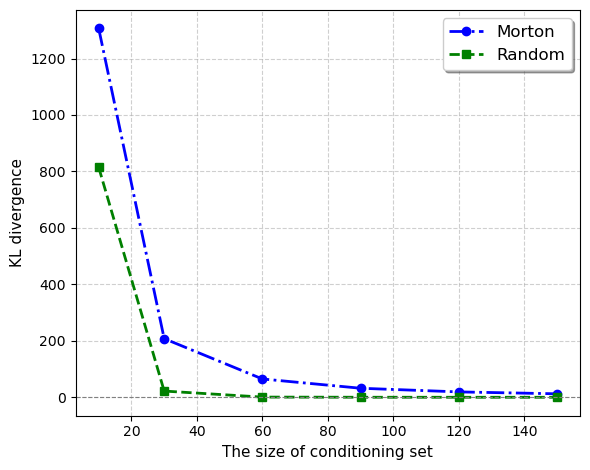

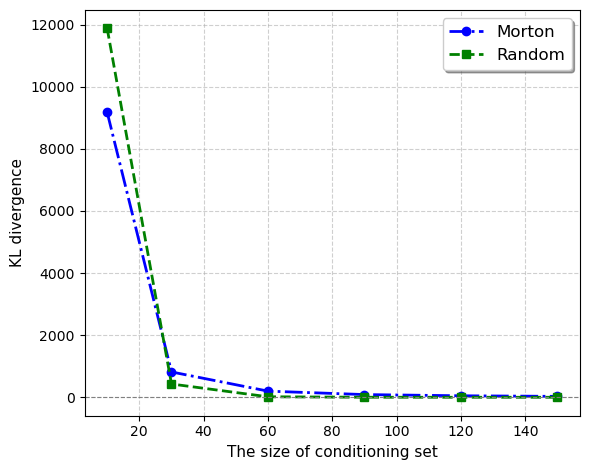

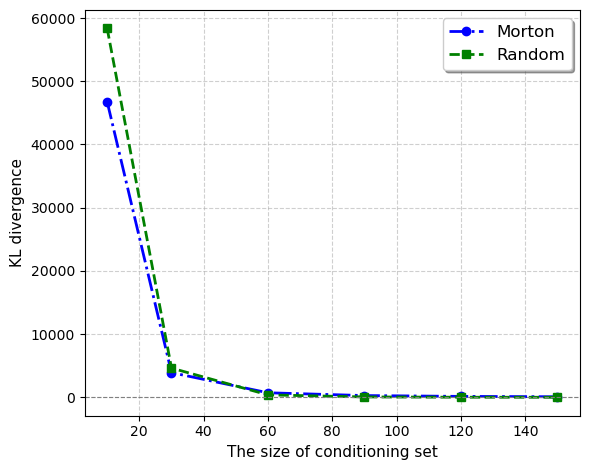

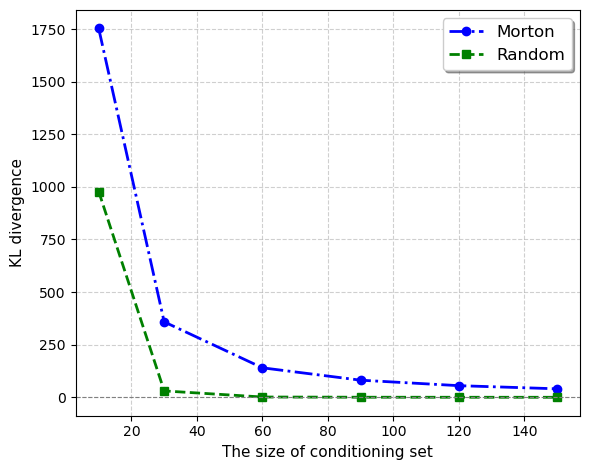

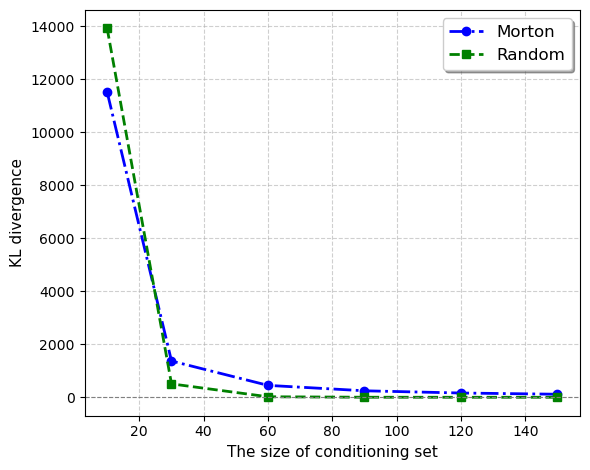

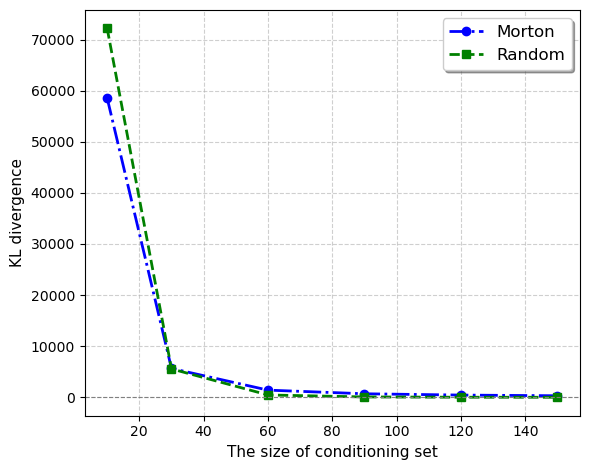

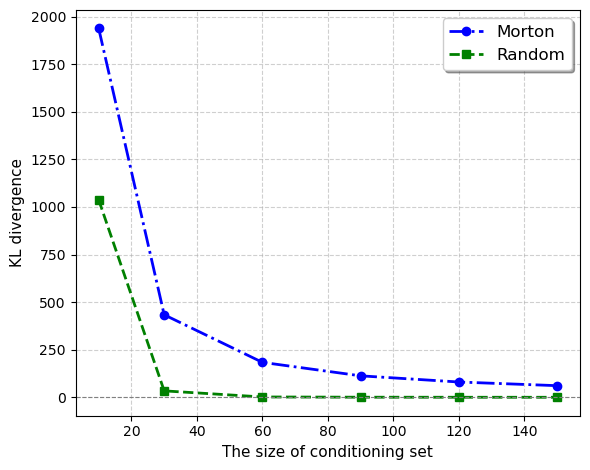

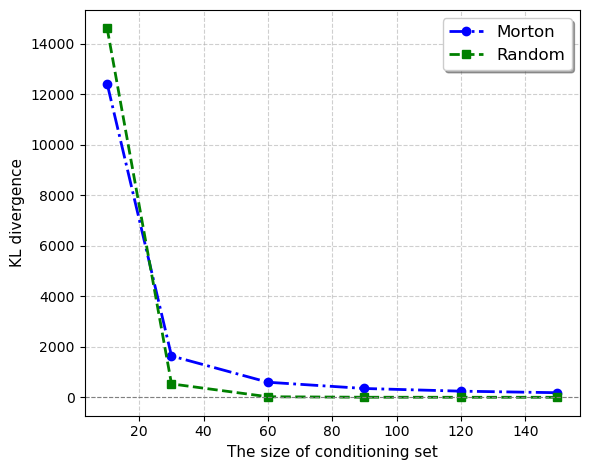

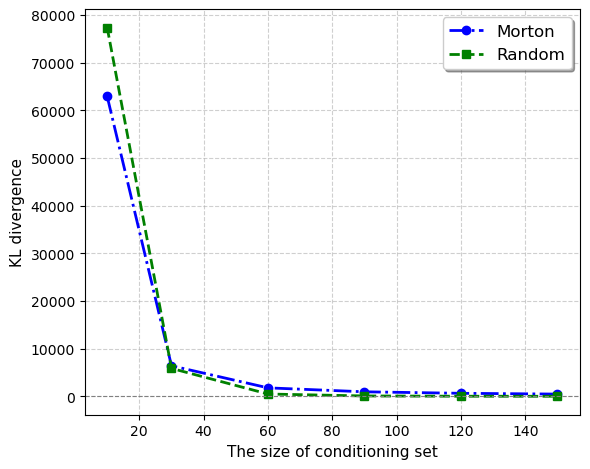

In [81]:
import matplotlib.pyplot as plt
import numpy as np

fig_dir = './fig'
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

def plot_kl(x, y1, y2, info):
    fig, ax = plt.subplots(figsize=(6, 4.8))
    ax.plot(x, y1, label='Morton', color='blue', linewidth=2, linestyle='-.', marker='o', markersize=6)
    ax.plot(x, y2, label='Random', color='green', linewidth=2, linestyle='--', marker='s', markersize=6)
    ax.set_xlabel('The size of conditioning set', fontsize=11)
    ax.set_ylabel('KL divergence', fontsize=11)
    # ax.set_yscale('log')
    ax.legend(fontsize=12, shadow=True, frameon=True)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.savefig(f'./fig/{info[1]}_{info[2]}.pdf')
    # plt.show()

for i in range(num_exps_):
    plot_kl(cs_set, allh_morton[i, :], allh_random[i, :], params[i])